In [1]:
    #import the libraries we need
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
    #paths for our test and validation files
train_data_dir = "C:/train"
val_data_dir = "C:/validation"

    # data preprocessing

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1.0/255)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

Found 1584 images belonging to 31 classes.
Found 340 images belonging to 31 classes.


In [3]:
import tensorflow as tf

    #we load our weights file here
weights_path = "C:/Users/Krishna/Downloads/resnet50v2_weights_tf_dim_ordering_tf_kernels_notop.h5"
class_names=['Alpinia Galanga (Rasna)', 'Amaranthus hybridus (Pigweed)','Amaranthus Viridis (Arive-Dantu)', 'Artocarpus Heterophyllus (Jackfruit)', 'Azadirachta Indica (Neem)', 'Basella Alba (Basale)', 'Brassica Juncea (Indian Mustard)', 'Carissa Carandas (Karanda)', 'Citrus Limon (Lemon)', 'Ficus Auriculata (Roxburgh fig)', 'Ficus Religiosa (Peepal Tree)', 'Hibiscus Rosa-sinensis', 'Jasminum (Jasmine)', 'Mangifera Indica (Mango)', 'Mentha (Mint)', 'Moringa Oleifera (Drumstick)', 'Muntingia Calabura (Jamaica Cherry-Gasagase)', 'Murraya Koenigii (Curry)', 'Nerium Oleander (Oleander)', 'Nyctanthes Arbor-tristis (Parijata)', 'Ocimum Tenuiflorum (Tulsi)', 'Piper Betle (Betel)', 'Plectranthus Amboinicus (Mexican Mint)', 'Pongamia Pinnata (Indian Beech)', 'Psidium Guajava (Guava)', 'Punica Granatum (Pomegranate)', 'Santalum Album (Sandalwood)', 'Syzygium Cumini (Jamun)', 'Syzygium Jambos (Rose Apple)', 'Tabernaemontana Divaricata (Crape Jasmine)', 'Trigonella Foenum-graecum (Fenugreek)']
num_classes = len(class_names)  


base_model = tf.keras.applications.ResNet50V2(weights=weights_path, include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

In [4]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#for test we took 10 epoches, you can take 50
num_epochs = 10

history = model.fit(
    train_generator,
    steps_per_epoch=15,  # Reduced to 15 steps per epoch, you can increase if you need
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=num_epochs)


Epoch 1/10
15/15 [==============================] - 47s 3s/step - loss: 3.2495 - accuracy: 0.1458 - val_loss: 2.6964 - val_accuracy: 0.3031
Epoch 2/10
15/15 [==============================] - 35s 2s/step - loss: 2.2545 - accuracy: 0.4292 - val_loss: 1.9666 - val_accuracy: 0.5406
Epoch 3/10
15/15 [==============================] - 37s 3s/step - loss: 1.6670 - accuracy: 0.6562 - val_loss: 1.5841 - val_accuracy: 0.6250
Epoch 4/10
15/15 [==============================] - 36s 2s/step - loss: 1.2880 - accuracy: 0.7271 - val_loss: 1.1687 - val_accuracy: 0.7688
Epoch 5/10
15/15 [==============================] - 34s 2s/step - loss: 1.0082 - accuracy: 0.8104 - val_loss: 1.0010 - val_accuracy: 0.7844
Epoch 6/10
15/15 [==============================] - 33s 2s/step - loss: 0.8419 - accuracy: 0.8646 - val_loss: 0.8658 - val_accuracy: 0.8125
Epoch 7/10
15/15 [==============================] - 33s 2s/step - loss: 0.6965 - accuracy: 0.8729 - val_loss: 0.7468 - val_accuracy: 0.8313
Epoch 8/10
15/15 [==

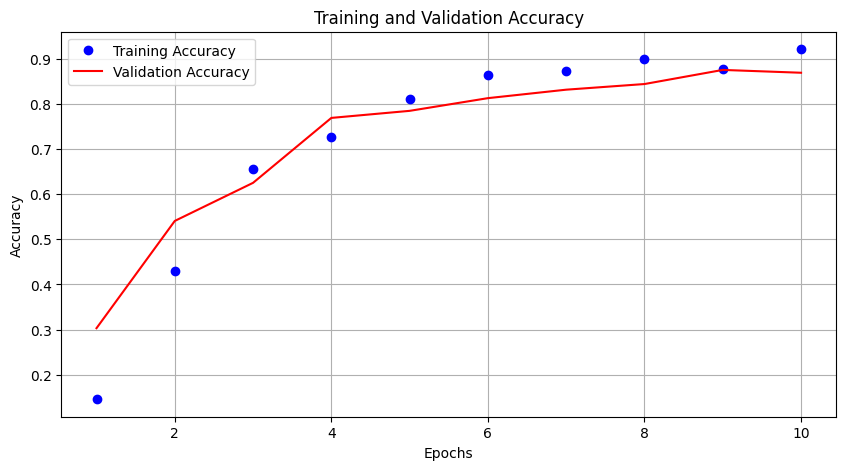

In [5]:
    # save the model
model.save('medical_herb_detection.h5')
val_generator.class_indices

    #plotting accuracy graph
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

1/1 [==============================] - 1s 1s/step


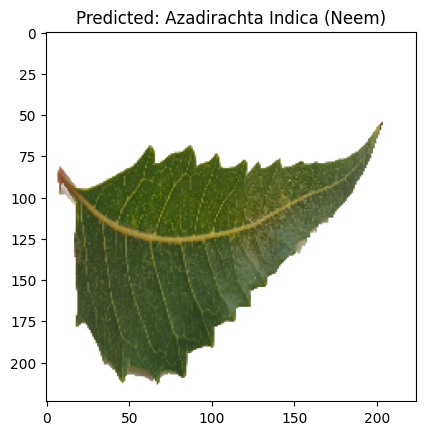

1/1 [==============================] - 0s 85ms/step


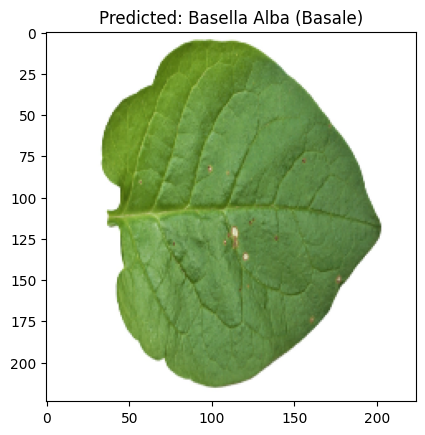

1/1 [==============================] - 0s 103ms/step


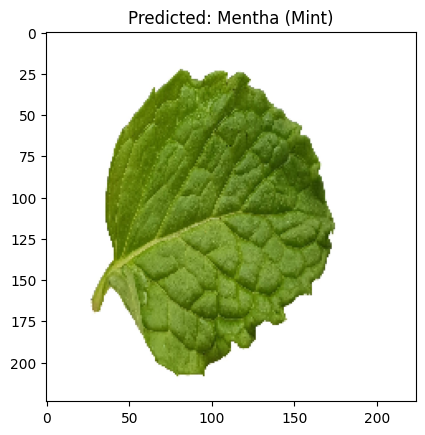

1/1 [==============================] - 0s 99ms/step


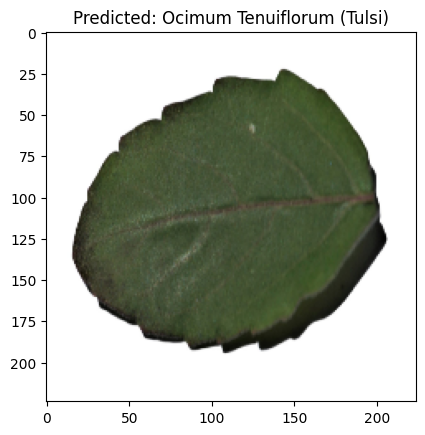

The predicted leaf name for image 1 is: Azadirachta Indica (Neem)
The predicted leaf name for image 2 is: Basella Alba (Basale)
The predicted leaf name for image 3 is: Mentha (Mint)
The predicted leaf name for image 4 is: Ocimum Tenuiflorum (Tulsi)


In [6]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np

    # Load the model
model = keras.models.load_model('medical_herb_detection.h5')

def classify_leaf(input_image_array):
    # Preprocess the image
    img_array = np.expand_dims(input_image_array, axis=0)
    img_array /= 255.
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])
    predicted_leaf_name = class_names[predicted_class_index]
    
    return predicted_leaf_name

def display_image_with_prediction(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    x = keras.preprocessing.image.img_to_array(img)
    predicted_name = classify_leaf(x)

    # Display the image and prediction
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_name}')
    plt.show()

    return predicted_name

if __name__ == "__main__":
    dir_path = "C:/test/test1"
    predicted_names = []

    for image_filename in os.listdir(dir_path):
        image_path = os.path.join(dir_path, image_filename)
        predicted_name = display_image_with_prediction(image_path)
        predicted_names.append(predicted_name)

    for i, predicted_name in enumerate(predicted_names):
        print(f'The predicted leaf name for image {i + 1} is: {predicted_name}') 

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from tensorflow import keras

train_data_dir = "C:/train1"
val_data_dir = "C:/validation1"

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1.0/255)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')


weights_path = "C:/Users/Krishna/Downloads/resnet50v2_weights_tf_dim_ordering_tf_kernels_notop.h5"
class_names = ['Azadirachta Indica (Neem)', 'Ocimum Tenuiflorum (Tulsi)']
num_classes = len(class_names)

base_model = tf.keras.applications.ResNet50V2(weights=weights_path, include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


num_epochs = 10
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=num_epochs)

model.save('medical_herb_detection.h5')


model = keras.models.load_model('medical_herb_detection.h5')

def classify_leaf(input_image_array):
    # Preprocess the image
    img_array = np.expand_dims(input_image_array, axis=0)
    img_array /= 255.
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])
    predicted_leaf_name = class_names[predicted_class_index]
    
    return predicted_leaf_name

def predict_leaves_in_directory(dir_path):
    predicted_names = []
    for image_filename in os.listdir(dir_path):
        image_path = os.path.join(dir_path, image_filename)
        img = keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
        x = keras.preprocessing.image.img_to_array(img)
        predicted_name = classify_leaf(x)
        predicted_names.append(predicted_name)
    return predicted_names

test_dir_path = "C:/test/test2"
predicted_names = predict_leaves_in_directory(test_dir_path)

for i, predicted_name in enumerate(predicted_names):
    print(f'The predicted leaf name for image {i + 1} is: {predicted_name}')


Found 96 images belonging to 2 classes.
Found 58 images belonging to 2 classes.
Epoch 1/10
3/3 [==============================] - 12s 3s/step - loss: 0.8568 - accuracy: 0.4896 - val_loss: 0.4849 - val_accuracy: 0.8125
Epoch 2/10
3/3 [==============================] - 6s 2s/step - loss: 0.2782 - accuracy: 0.9271 - val_loss: 0.3145 - val_accuracy: 0.8125
Epoch 3/10
3/3 [==============================] - 6s 2s/step - loss: 0.1351 - accuracy: 0.9688 - val_loss: 0.0810 - val_accuracy: 0.9688
Epoch 4/10
3/3 [==============================] - 5s 2s/step - loss: 0.0758 - accuracy: 0.9896 - val_loss: 0.0524 - val_accuracy: 1.0000
Epoch 5/10
3/3 [==============================] - 6s 2s/step - loss: 0.0485 - accuracy: 0.9896 - val_loss: 0.0523 - val_accuracy: 1.0000
Epoch 6/10
3/3 [==============================] - 6s 2s/step - loss: 0.0393 - accuracy: 0.9896 - val_loss: 0.0089 - val_accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 6s 2s/step - loss: 0.0288 - accuracy: 1.0000 - 